In [13]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from scipy.stats import pearsonr, spearmanr
import h3pandas
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pickle
from warnings import filterwarnings
import matplotlib.colors as colors
import geopandas as gpd 
import sys
import os
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from plotting_utils import get_color_dict
color_dict = get_color_dict()

filterwarnings('ignore')
tqdm.pandas()

plt.rcParams.update({'font.family':'arial'})

from sklearn.preprocessing import StandardScaler

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from model_utils import *


In [4]:
with open('../trophic_niches.txt','r') as f:
    niche_list = f.read().strip().split('\n')

In [5]:
beta_geographic_summary = pd.read_csv('../../data/D07.BYM2_summary/beta_geographic_summary.csv')


In [6]:
beta_geographic_summary['beta_sig'] = ((beta_geographic_summary['beta_mean'] - 2* beta_geographic_summary['beta_std']) *\
(beta_geographic_summary['beta_mean'] + 2* beta_geographic_summary['beta_std']) > 0).values

# beta_geographic_summary = beta_geographic_summary[beta_geographic_summary['beta_sig']==True]
        

In [7]:
# Get resource variability
all_NDVI = []
for year in range(2010, 2021):
    NDVI = pd.read_csv(f'../../data/D04.environmental_data/GreenWave_agg_h3_02_{year}.csv')
    NDVI = NDVI.groupby('h3_02')[['mean_NDVI']].std()
    all_NDVI.append(NDVI)
    
NDVI = pd.concat(all_NDVI, axis=1).mean(axis=1).reset_index(drop=False)
NDVI.columns = ['h3_02', 'Resource seasonality']


In [23]:
reg_res = []
all_cue_variability = {}
for cue in ['tmin', 'delta_NDVI']:
    all_cue_variability[cue] = []
    for niche in color_dict.keys():
        
        # load cue data
        cue_data = pd.read_csv(f'../../data/D07.BYM2_summary/modeling_data_with_posterior_est_niche_{niche}_env_{cue}.csv')
        cue_data = cue_data[['h3_02',f'mean_expected_trace_by_{cue}']].groupby('h3_02').std().reset_index(drop=False)
        cue_data.columns = ['h3_02', 'Cue variability']
        all_cue_variability[cue].append(cue_data['Cue variability'].mean())
        
    

In [24]:
from scipy.stats import ttest_rel
ttest_rel(all_cue_variability['tmin'], all_cue_variability['delta_NDVI'])


TtestResult(statistic=-23.989600406906124, pvalue=3.6022714693952627e-10, df=10)

In [25]:
np.mean(all_cue_variability['tmin']), np.mean(all_cue_variability['delta_NDVI'])

(11.946289817114222, 15.690779002304481)

## Regression with OLS


In [18]:
reg_res = []
for cue in ['tmin', 'delta_NDVI']:
    for niche in color_dict.keys():
        
        # load cue data
        cue_data = pd.read_csv(f'../../data/D07.BYM2_summary/modeling_data_with_posterior_est_niche_{niche}_env_{cue}.csv')
        cue_data = cue_data[['h3_02',f'mean_expected_trace_by_{cue}']].groupby('h3_02').std().reset_index(drop=False)
        cue_data.columns = ['h3_02', 'Cue variability']
        
        sub_beta = beta_geographic_summary[
            (beta_geographic_summary['env_var'] == cue) & (beta_geographic_summary['niche'] == niche)
        ]
        
        # merge dfs
        regression_data = sub_beta[['h3_02','lng','lat','beta_mean','beta_std']].merge(
            NDVI, on='h3_02', how='left'
        ).merge(
            cue_data, on='h3_02', how='left'
        ).dropna()
        
        
        X = regression_data[['lat', 'Resource seasonality', 'Cue variability']]
        X = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)
        X = sm.add_constant(X)
        y = regression_data[['beta_mean']].values
        
        import statsmodels.api as sm
        model = sm.OLS(y, X).fit()
        res = model.get_robustcov_results()
        
        reg_res.append({
            'cue':cue,
            'niche':niche,
            'coef_lat': res.params[1],
            'coef_lat_CI_left': res.conf_int()[1,0],
            'coef_lat_CI_right': res.conf_int()[1,1],
            'coef_resource_seasonality': res.params[2],
            'coef_resource_seasonality_CI_left': res.conf_int()[2,0],
            'coef_resource_seasonality_CI_right': res.conf_int()[2,1],
            'coef_cue_variability': res.params[3],
            'coef_cue_variability_CI_left': res.conf_int()[3,0],
            'coef_cue_variability_CI_right': res.conf_int()[3,1]
        })
  
reg_res = pd.DataFrame(reg_res)
reg_res


,cue,niche,coef_lat,coef_lat_CI_left,coef_lat_CI_right,coef_resource_seasonality,coef_resource_seasonality_CI_left,coef_resource_seasonality_CI_right,coef_cue_variability,coef_cue_variability_CI_left,coef_cue_variability_CI_right
0,tmin,all,-0.083791,-0.090919,-0.076664,0.011991,0.004657,0.019326,0.015676,0.010333,0.021019
1,tmin,Trophic_Niche_Aquatic_predator,-0.132826,-0.142574,-0.123078,-0.019729,-0.028024,-0.011434,0.034683,0.026878,0.042489
2,tmin,Trophic_Niche_Frugivore,-0.043174,-0.047316,-0.039033,-0.015863,-0.020100,-0.011625,0.029346,0.025612,0.033081
3,tmin,Trophic_Niche_Granivore,-0.084725,-0.089887,-0.079562,-0.025913,-0.030680,-0.021147,0.030757,0.026167,0.035348
4,tmin,Trophic_Niche_Herbivore_aquatic,-0.082241,-0.088656,-0.075826,0.001332,-0.007128,0.009792,0.055926,0.049855,0.061997
5,tmin,Trophic_Niche_Herbivore_terrestrial,-0.085660,-0.090474,-0.080847,-0.009100,-0.014334,-0.003866,0.031577,0.027326,0.035828
6,tmin,Trophic_Niche_Invertivore,-0.116087,-0.129980,-0.102194,-0.039122,-0.052402,-0.025841,0.081962,0.070121,0.093803
7,tmin,Trophic_Niche_Nectarivore,-0.035988,-0.043930,-0.028047,-0.018113,-0.027750,-0.008476,0.095724,0.086819,0.104629
8,tmin,Trophic_Niche_Omnivore,-0.064533,-0.070652,-0.058414,-0.030514,-0.036480,-0.024549,0.031884,0.026471,0.037297
9,tmin,Trophic_Niche_Scavenger,-0.071331,-0.078412,-0.064250,-0.002235,-0.010112,0.005641,0.085295,0.078256,0.092334


## Regression with BYM2


In [38]:
must_converge = [
 'mu_alpha',
 'mu_beta1',
 'mu_beta2',
 'mu_beta3',
 'sigma_alpha',
 'beta1_sigma_phi_BYM2',
 'beta2_sigma_phi_BYM2',
 'beta3_sigma_phi_BYM2',
 'sigma_error',
 'sensitivity_latent'
]

almost_converge = [
 'theta_error',
 'theta_alpha',
 'alpha',
 'beta1',
 'beta2',
 'beta3',
 'phi_ICAR_beta1_BYM2_component',
 'logit_rho_beta1_BYM2_component',
 'theta_ICAR_beta1_BYM2_component',
 'phi_ICAR_beta2_BYM2_component',
 'logit_rho_beta2_BYM2_component',
 'theta_ICAR_beta2_BYM2_component',
 'phi_ICAR_beta3_BYM2_component',
 'logit_rho_beta3_BYM2_component',
 'theta_ICAR_beta3_BYM2_component',
 'scaling_factor_ICAR_beta1_BYM2_component',
 'scaling_factor_ICAR_beta2_BYM2_component',
 'scaling_factor_ICAR_beta3_BYM2_component',
 'rho_ICAR_beta1_BYM2_component',
 'convolved_re_beta1_BYM2_component',
 'rho_ICAR_beta2_BYM2_component',
 'convolved_re_beta2_BYM2_component',
 'rho_ICAR_beta3_BYM2_component',
 'convolved_re_beta3_BYM2_component',
]


In [99]:

for cue in ['tmin', 'delta_NDVI']:
    for niche in tqdm(color_dict.keys(), total=len(color_dict.keys())):
        
        # load cue data
        cue_data = pd.read_csv(f'../../data/D07.BYM2_summary/modeling_data_with_posterior_est_niche_{niche}_env_{cue}.csv')
        cue_data = cue_data[['h3_02',f'mean_expected_trace_by_{cue}']].groupby('h3_02').std().reset_index(drop=False)
        cue_data.columns = ['h3_02', 'Cue variability']
        
        sub_beta = beta_geographic_summary[
            (beta_geographic_summary['env_var'] == cue) & (beta_geographic_summary['niche'] == niche)
        ]
        
        # merge dfs
        regression_data = sub_beta[['h3_02','lng','lat','beta_mean','beta_std']].merge(
            NDVI, on='h3_02', how='left'
        ).merge(
            cue_data, on='h3_02', how='left'
        ).dropna()
        
        regression_data[['lat_standardized', 'Resource_seasonality_standardized', 'Cue_variability_standardized']] = StandardScaler().fit_transform(regression_data[['lat', 'Resource seasonality', 'Cue variability']])
        
        ####
        univ_cell = get_univ_cell(regression_data)

        ###
        univ_cell = univ_cell[(univ_cell.lng>=regression_data.lng.min()) & (univ_cell.lng<=regression_data.lng.max()) & \
                (univ_cell.lat>=regression_data.lat.min()) & (univ_cell.lat<=regression_data.lat.max())]
        regression_data = regression_data[regression_data['h3_02'].isin(set(univ_cell.index))]

        ###
        adj_mat = calculat_adj_mat(univ_cell)
        univ_cell = univ_cell.reset_index(drop=False)
        cell_encoder = LabelEncoder().fit(univ_cell['h3_02'])
        univ_cell['cell_index'] = cell_encoder.transform(univ_cell['h3_02'])
        regression_data['cell_index'] = cell_encoder.transform(regression_data['h3_02'])
        univ_pairs_adj_df = get_pair_df_from_df(univ_cell, adj_mat)

        #
        model = build_model(regression_data, univ_cell, univ_pairs_adj_df)
        idata = Run_Model(model, saving_path=f'../../data/D10.Explaining_sensitivity_regression/{niche}_{cue}_sensitivity.pkl',
                        must_converge_var=must_converge,
                        almost_converge_var=almost_converge,
                        max_iter=8, max_tune=100000, SAMPLE_SIZE=2000, TUNES=2000)

        

  0%|          | 0/11 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [98]:
regression_data


,h3_02,lng,lat,beta_mean,beta_std,Resource seasonality,Cue variability,lat_standardized,Resource_seasonality_standardized,Cue_variability_standardized,cell_index
0,820007fffffffff,36.216216,77.747748,0.678388,0.147525,152.980322,13.900269,1.971370,-1.123974,0.280425,0
1,82001ffffffffff,46.666667,79.549550,0.564903,0.152140,113.866717,11.350746,2.059975,-1.164857,-0.188523,3
2,820027fffffffff,28.648649,75.765766,0.919326,0.095190,309.178094,13.380005,1.873906,-0.960712,0.184730,4
3,82002ffffffffff,22.882883,78.108108,0.705961,0.143634,218.557514,11.497427,1.989091,-1.055431,-0.161544,5
4,82004ffffffffff,-37.297297,82.972973,0.585198,0.161891,344.220007,8.527168,2.228323,-0.924086,-0.707880,8
...,...,...,...,...,...,...,...,...,...,...,...
1489,827af7fffffffff,43.783784,4.054054,1.081605,0.144492,493.102694,13.062464,-1.652544,-0.768470,0.126322,2632
1490,828297fffffffff,15.675676,1.891892,1.077073,0.152592,490.510426,25.644889,-1.758869,-0.771179,2.440679,2655
1491,82829ffffffffff,13.153153,2.972973,1.091038,0.163083,1061.155183,20.478742,-1.705706,-0.174727,1.490441,2656
1492,8282d7fffffffff,8.468468,2.252252,0.976416,0.144841,1255.340069,28.801063,-1.741148,0.028241,3.021212,2658


In [100]:
posterior_samples.posterior_predictive['beta1'].values.shape


(4, 2000, 2662)

## Summarize BYM2 results

In [101]:
reg_res = []

for cue in ['tmin', 'delta_NDVI']:
    for niche in tqdm(color_dict.keys(), total=len(color_dict.keys())):
        with open(f'../../data/D10.Explaining_sensitivity_regression/{niche}_{cue}_sensitivity.pkl','rb') as f:
            data = pickle.load(f)
            reg_res.append({
                'cue':cue,
                'niche':niche,
                'coef_lat': np.concatenate(data.posterior['mu_beta1'], axis=0).mean(),
                'coef_lat_CI_left': np.quantile(np.concatenate(data.posterior['mu_beta1'], axis=0), 0.025),
                'coef_lat_CI_right': np.quantile(np.concatenate(data.posterior['mu_beta1'], axis=0), 0.975),
                'coef_resource_seasonality': np.concatenate(data.posterior['mu_beta2'], axis=0).mean(),
                'coef_resource_seasonality_CI_left': np.quantile(np.concatenate(data.posterior['mu_beta2'], axis=0), 0.025),
                'coef_resource_seasonality_CI_right': np.quantile(np.concatenate(data.posterior['mu_beta2'], axis=0), 0.975),
                'coef_cue_variability': np.concatenate(data.posterior['mu_beta3'], axis=0).mean(),
                'coef_cue_variability_CI_left': np.quantile(np.concatenate(data.posterior['mu_beta3'], axis=0), 0.025),
                'coef_cue_variability_CI_right': np.quantile(np.concatenate(data.posterior['mu_beta3'], axis=0), 0.975)
            })

reg_res = pd.DataFrame(reg_res)
reg_res


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

,cue,niche,coef_lat,coef_lat_CI_left,coef_lat_CI_right,coef_resource_seasonality,coef_resource_seasonality_CI_left,coef_resource_seasonality_CI_right,coef_cue_variability,coef_cue_variability_CI_left,coef_cue_variability_CI_right
0,tmin,all,-0.077631,-0.087719,-0.067431,0.004536,-0.006141,0.015027,0.018496,0.011055,0.026341
1,tmin,Trophic_Niche_Aquatic_predator,-0.123690,-0.137816,-0.109971,-0.027652,-0.039961,-0.014704,0.046897,0.037911,0.056090
2,tmin,Trophic_Niche_Frugivore,-0.038593,-0.047027,-0.030057,-0.018608,-0.027171,-0.010004,0.032195,0.026174,0.038315
3,tmin,Trophic_Niche_Granivore,-0.082257,-0.091522,-0.073207,-0.029492,-0.038653,-0.020267,0.033348,0.026390,0.040471
4,tmin,Trophic_Niche_Herbivore_aquatic,-0.082073,-0.093809,-0.069818,-0.005251,-0.017625,0.006940,0.054039,0.045443,0.062867
5,tmin,Trophic_Niche_Herbivore_terrestrial,-0.083618,-0.092841,-0.074491,-0.012836,-0.022261,-0.003254,0.031031,0.024370,0.038123
6,tmin,Trophic_Niche_Invertivore,-0.103101,-0.123419,-0.082706,-0.053615,-0.073683,-0.033602,0.085566,0.069192,0.104789
7,tmin,Trophic_Niche_Nectarivore,-0.035792,-0.050098,-0.021665,-0.020558,-0.036225,-0.005147,0.090265,0.077563,0.103029
8,tmin,Trophic_Niche_Omnivore,-0.064820,-0.075238,-0.054665,-0.031555,-0.041639,-0.021740,0.033395,0.025586,0.041382
9,tmin,Trophic_Niche_Scavenger,-0.072396,-0.084909,-0.060035,-0.000840,-0.013542,0.011869,0.088808,0.077910,0.099697


In [102]:
reg_res.to_csv('../../data/D10.Explaining_sensitivity_regression/coef.csv', index=False)

In [109]:
print(reg_res[(reg_res['cue']=='tmin') & (reg_res['niche']!='all')]['coef_lat'].mean(), reg_res[(reg_res['cue']=='tmin') & (reg_res['niche']!='all')]['coef_lat'].std())
print(reg_res[(reg_res['cue']=='tmin') & (reg_res['niche']!='all')]['coef_cue_variability'].mean(), reg_res[(reg_res['cue']=='tmin') & (reg_res['niche']!='all')]['coef_cue_variability'].std())
print(reg_res[(reg_res['cue']=='delta_NDVI') & (reg_res['niche']!='all')]['coef_lat'].mean(), reg_res[(reg_res['cue']=='delta_NDVI') & (reg_res['niche']!='all')]['coef_lat'].std())
print(reg_res[(reg_res['cue']=='delta_NDVI') & (reg_res['niche']!='all')]['coef_cue_variability'].mean(), reg_res[(reg_res['cue']=='delta_NDVI') & (reg_res['niche']!='all')]['coef_cue_variability'].std())


-0.07580366156542725 0.02648900341855741
0.05561486284621707 0.024597396230348727
-0.04492767084687685 0.03256749892953829
0.050267628553431955 0.017233499104413987


## plot

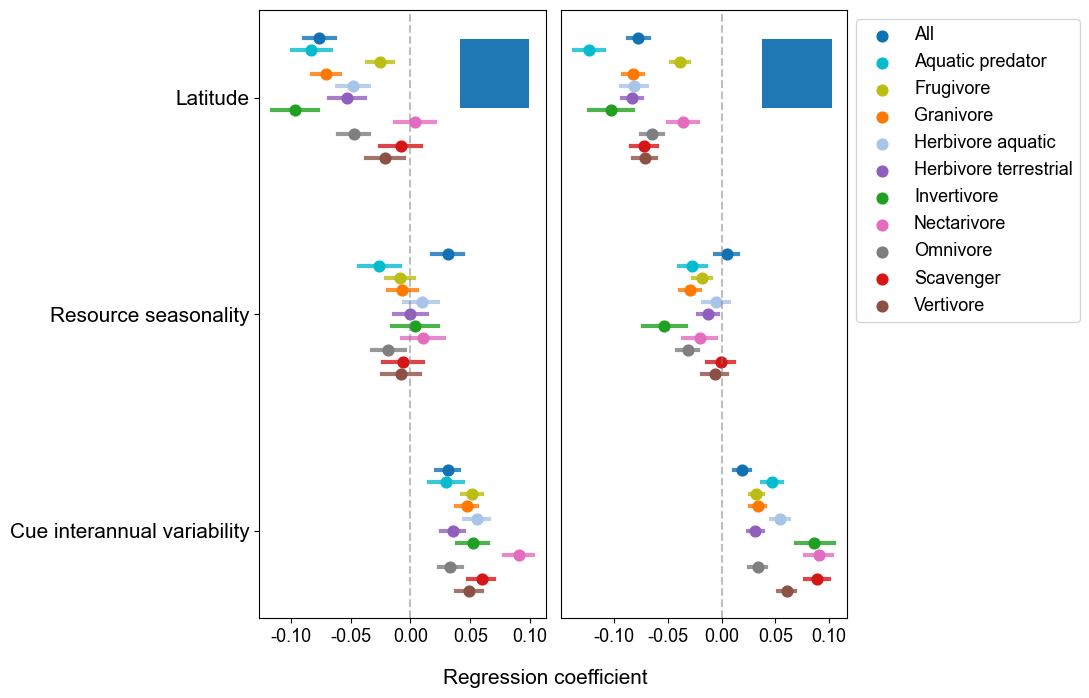

In [53]:
fig,axs = plt.subplots(1,2,figsize=(11,10*0.7))

tmp1 = reg_res[reg_res['cue']=='delta_NDVI'].reset_index(drop=True)
tmp2 = reg_res[reg_res['cue']=='tmin'].reset_index(drop=True)

for ax_index, tmp in zip([0,1], [tmp1, tmp2]):
    y_location_dict = {i:[] for i in ['lat', 'resource_seasonality', 'cue_variability']}
    for index, line in tmp.iterrows():
        for var_num, var_ in enumerate(['lat', 'resource_seasonality', 'cue_variability']):
            if var_num == 0:
                label=line['niche'].split('Trophic_Niche_')[-1].replace('_',' ').capitalize()
            else:
                label=None
            
            axs[ax_index].scatter(
                [line[f'coef_{var_}']],
                [-(index+var_num*18)],
                label=label,
                color=color_dict[line['niche']],s=60
            )
            axs[ax_index].plot(
                [line[f'coef_{var_}_CI_left'], line[f'coef_{var_}_CI_right']],
                [-(index+var_num*18), -(index+var_num*18)],
                color=color_dict[line['niche']],linewidth=3,alpha=0.8
            )
            
            y_location_dict[var_].append(-(index+var_num*18))
        
    if ax_index == 0:
        axs[ax_index].set_yticks([np.mean(y_location_dict[var_]) for var_ in y_location_dict], 
                    ['Latitude','Resource seasonality','Cue interannual variability'],
                    fontsize=15)
    else:
        axs[ax_index].set_yticks([])
    
    if ax_index == 0:
        axs[ax_index].set_xticks([-0.10,-0.05,0.00,0.05,0.10])
        
    axs[ax_index].set_xticklabels(['{:.2f}'.format(i) for i in axs[ax_index].get_xticks()], fontsize=13)
    axs[ax_index].axvline(0, linestyle='dashed',color='grey',alpha=0.5)
    
    if ax_index == 1:
        axs[ax_index].legend(bbox_to_anchor=(1,1), fontsize=13)
        
fig.supxlabel('Regression coefficient', fontsize=15)
plt.tight_layout()
# fig.subplots_adjust(wspace=0.0)

import skunk
from matplotlib.offsetbox import AnnotationBbox
size=(50,50)

#
box = skunk.Box(size[0], size[1], 'leaf')
ab = AnnotationBbox(box, (0.07, np.mean(y_location_dict['lat'])+2),
                    xycoords='data',
                    boxcoords='data',
                    frameon=False)
axs[0].add_artist(ab)

#
box = skunk.Box(size[0], size[1], 'temperature')
ab = AnnotationBbox(box, (0.07, np.mean(y_location_dict['lat'])+2),
                    xycoords='data',
                    boxcoords='data',
                    frameon=False)
axs[1].add_artist(ab)

svg = skunk.insert({
                    'leaf':f"../../silhouette/SVG/leaf.svg",
                    'temperature':f"../../silhouette/SVG/temperature.svg"})

import cairosvg
cairosvg.svg2pdf(bytestring=svg, write_to='Fig4.pdf')

# plt.tight_layout()
